# Credit Risk Modeling and Portfolio Loss Distributions

This notebook explores credit risk modeling concepts, focusing on the impact of correlation and recovery rates on portfolio loss distributions and credit default swap (CDS) spreads. The workflow includes:

- Simulating portfolio losses under varying asset correlations (Beta) and analyzing the resulting unconditional and conditional loss distributions.
- Visualizing how changes in correlation affect the shape and tail risk of the loss distribution.
- Calculating survival probabilities and conditional survival probabilities for credit instruments, and examining how these probabilities change with different correlation structures.
- Computing and plotting forward CDS spreads as a function of correlation and time, illustrating the relationship between default risk and market factors.

The notebook leverages Python libraries such as NumPy, pandas, matplotlib, and SciPy for numerical analysis and visualization. Mathematical derivations and interpretations accompany the code to provide a comprehensive understanding of the results.

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from numpy.linalg import inv
from cvxopt import matrix, solvers
import cvxpy as cp
import warnings
import yfinance as yf
import os
from scipy.optimize import minimize, LinearConstraint
from scipy.stats import norm
from scipy.special import ndtri
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
import seaborn as sns

In [4]:
def A_i(N, Beta, R):
    Z = np.random.standard_normal(1)
    eps = np.random.standard_normal(N)
    As = Beta*Z +np.sqrt(1-Beta**2)*eps
    return Z, eps, As

# Problem 1

With a recovery rate of 30% we see that for 0 Beta, the unconditional loss distribution is greatest around .03*200*(1-.3) which is 4.2 which we see in orange below. When you increase the beta to 0.2 it shifts to the left and gets a fatter tail as there is more reliance on the market factor z. For beta of 0.4 it shifts even more and has an even fatter tail because it is even more reliant on the market factor z and less reliant on idiosyncratic risk. Thus more default(or do not default) together more frequently.

In [315]:
Zs = np.linspace(-3.5,3.5,1000)
#Zs=[-3]
ms = np.arange(0,50, 1)
def homo_port(N, Beta, R, Zs, ms, haz, t): 
    cond_losses = []
    uncond_losses = []
    Q_t = np.exp(-haz*t)
    PD = 1-Q_t
    C_t = ndtri(PD) 
    for m in ms: 
        cond_loss = 0.0
        uncond_loss = 0.0
        for z in Zs: 
            prob_def_cond = norm.cdf((C_t-Beta*z)/np.sqrt(1-(Beta**2)))
            cond_loss = cond_loss +  math.comb(N, m)*(prob_def_cond**m)*((1-prob_def_cond)**(N-m))
            uncond_loss = uncond_loss +  cond_loss*norm.cdf(z)
        
        cond_losses.append(cond_loss)
        uncond_losses.append(uncond_loss)
    return cond_losses, uncond_losses
            

In [316]:
norm.ppf(.01)

-2.3263478740408408

In [317]:
N  = 200
Beta = .2
R = .3
haz = .03
t = 1
res1 = homo_port(N, Beta, R, Zs, ms, haz, t)
res1u = res1[1]/sum(res1[1])
res1c = res1[0]/sum(res1[0])
Beta = 0
res2 = homo_port(N, Beta, R, Zs, ms, haz, t)
res2u = res2[1]/sum(res2[1])
res2c = res2[0]/sum(res2[0])
Beta = .4
res3 = homo_port(N, Beta, R, Zs, ms, haz, t)
res3u = res3[1]/sum(res3[1])
res3c = res3[0]/sum(res3[0])

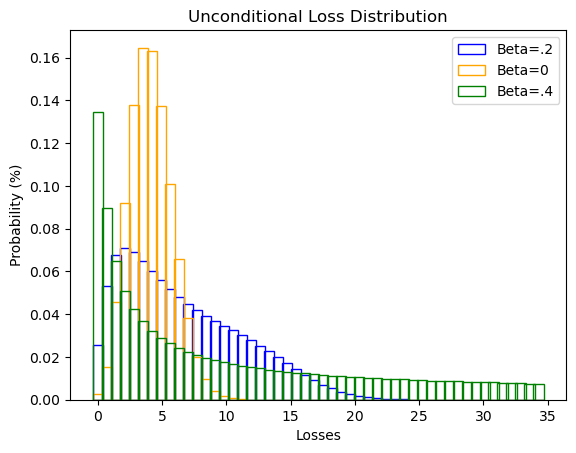

In [318]:
plt.bar(ms*(1-R),res1u, edgecolor = 'blue', fill = False, label = 'Beta=.2')
plt.bar(ms*(1-R),res2u, edgecolor = 'orange', fill = False, label = 'Beta=0')
plt.bar(ms*(1-R),res3u, edgecolor = 'green', fill = False, label = 'Beta=.4')
plt.legend()
plt.title('Unconditional Loss Distribution')
plt.xlabel('Losses')
plt.ylabel('Probability (%)')
plt.show()

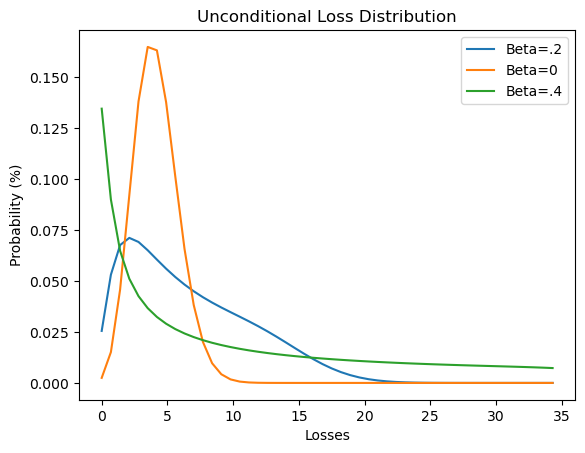

In [319]:
plt.plot(ms*(1-R),res1u,  label = 'Beta=.2')
plt.plot(ms*(1-R),res2u,  label = 'Beta=0')
plt.plot(ms*(1-R),res3u,  label = 'Beta=.4')
plt.legend()
plt.title('Unconditional Loss Distribution')
plt.xlabel('Losses')
plt.ylabel('Probability (%)')
plt.show()

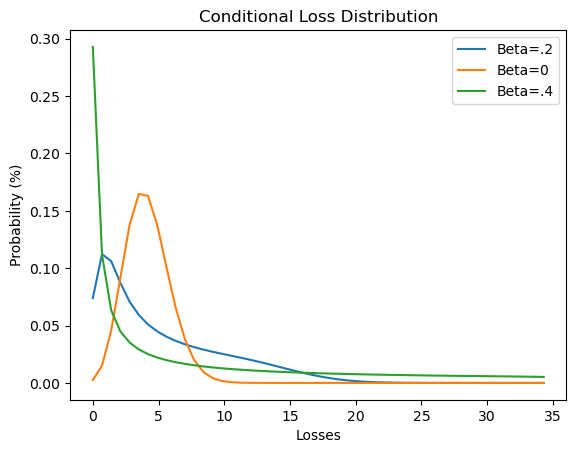

In [320]:
plt.plot(ms*(1-R),res1c, label = 'Beta=.2')
plt.plot(ms*(1-R),res2c, label = 'Beta=0')
plt.plot(ms*(1-R),res3c, label = 'Beta=.4')
plt.legend()
plt.title('Conditional Loss Distribution')
plt.xlabel('Losses')
plt.ylabel('Probability (%)')
plt.show()

In [184]:
sum(res2u*ms*(1-R))

4.137625303202169

In [11]:
res1c

array([0.0543857 , 0.10040938, 0.10895373, 0.09689594, 0.08147943,
       0.06883228, 0.0594182 , 0.05239216, 0.04697747, 0.04264095,
       0.03901951, 0.03584833, 0.03292178, 0.03007948, 0.02720722,
       0.0242437 , 0.02118482, 0.0180801 , 0.01501917, 0.01211074,
       0.0094594 , 0.00714593, 0.0052155 , 0.00367524, 0.0024996 ,
       0.00164058, 0.00103919, 0.0006354 , 0.00037513, 0.00021393])

In [12]:
res1u

array([0.01895648, 0.0461993 , 0.06596757, 0.07479239, 0.0760587 ,
       0.07350007, 0.06939775, 0.06487752, 0.06043162, 0.05623615,
       0.05230621, 0.04857123, 0.0449188 , 0.0412286 , 0.0374033 ,
       0.03339457, 0.02921892, 0.02495831, 0.020745  , 0.01673447,
       0.01307453, 0.00987886, 0.00721118, 0.00508208, 0.00345669,
       0.0022689 , 0.00143725, 0.00087882, 0.00051886, 0.0002959 ])

# Problem 2

a. We see from the first set of graphs below that when the correlation is 0, the survival probability starting at time t until time T Q(t,T) is equal to the conditional survival probability given that credit 1 defaults at time t.

\begin{equation}
Q(t,T) = \hat{Q}(t,T)
\end{equation}

We also see that a positive correlation corresponds to a lesser survival probability the greater that (T-t) is. As the magnitude of the correlation increases, the difference in conditional survival probability and the regular survival probability increases as well. With a negative correlation we see that the conditional survival probability forward curve is above the unconditional forward survival curve. This indicates higher survival probabilities.
<br>
<br>
Note the plots below are when credit A defaults at time t, what is the probability that it survives until maturity(T=10), so when t = 9.9 then credit B does not have much time to default so the Survival Probability is close to 1. When t = .1 then the Survival Probability is low since you have more time until you reach maturity T=10 so more chance to default. 
<br>
<br>
b. The conditional spread curve of D2 is displayed at the bottom. As the correlation increases, the spread is higher since the probability that D2 will default given that D1 defaults at time t is much higher thus a greater spread is required. It is a flat line with no correlation since the initial spread is flat at 100. With negative correlation, given that Credit 1 has defaulted, it decreases the chances that credit 2 will default thus a lower spread is required since there is less chance of default. As t approaches T this trends to initial flat spread = 100 since the difference in the survival probabilities is much less than for a greater gap between T and t.

In [254]:
def calc_thresh(haz, T):
    col = ['Q(T)','CPD', 'C(T)']
    
    df = pd.DataFrame(index = T, columns = col)
    for i in range(len(T)):    
        Q_t = np.exp(-haz*T[i])
        CPD = 1-Q_t
        C_t = ndtri(CPD)
        df.iloc[i] = [Q_t,CPD,C_t]
    return df 

In [255]:
T = np.arange(0.1,30.1,.1)
survival= calc_thresh(.03,T)
survival

,Q(T),CPD,C(T)
0.1,0.997004,0.002996,-2.748273
0.2,0.994018,0.005982,-2.513202
0.3,0.99104,0.00896,-2.367283
0.4,0.988072,0.011928,-2.259431
0.5,0.985112,0.014888,-2.173056
...,...,...,...
29.6,0.411478,0.588522,0.223745
29.7,0.410245,0.589755,0.226914
29.8,0.409016,0.590984,0.230076
29.9,0.407791,0.592209,0.233231


In [336]:
def calc_cond_surv(corr, haz2, ts, T, haz1):
    col = ['Q(T|t)','Q(T|t) cond']
    df = pd.DataFrame(index = ts, columns = col)
    Q_T = np.exp(-haz2*T)
    CPD = 1-Q_T
    Cb_T = ndtri(CPD)
    
    for t in ts:
        Q_t = np.exp(-haz2*t)
        CPD = 1-Q_t
        Cb_t = ndtri(CPD)
        Q_t_T = 1-((norm.cdf(Cb_T)-norm.cdf(Cb_t))/(1-norm.cdf(Cb_t)))
        df['Q(T|t)'].loc[t] = Q_t_T
        
        Qa_t=np.exp(-haz1*t)
        CPDa = 1-Qa_t
        Ca_t = ndtri(CPDa)
        num = norm.cdf((Cb_T-corr*Ca_t)/np.sqrt(1-corr**2))-norm.cdf((Cb_t-corr*Ca_t)/np.sqrt(1-corr**2))
        den = 1-norm.cdf((Cb_t-corr*Ca_t)/np.sqrt(1-corr**2))
        Q_t_T_cond = 1-num/den
        df['Q(T|t) cond'].loc[t] = Q_t_T_cond
    
    return df

In [339]:
ts = np.arange(0.1,10,.1)
T = 10
corr = 0
haz1 = .03
haz2 = 0.03
survivals = calc_cond_surv(corr, haz2, ts, T,haz1)
corr = 0.1
survivals1 = calc_cond_surv(corr, haz2, ts, T,haz1)
corr = 0.3
survivals2 = calc_cond_surv(corr, haz2, ts, T,haz1)
corr = -0.1
survivals3 = calc_cond_surv(corr, haz2, ts, T,haz1)


survivals3.head()

,Q(T|t),Q(T|t) cond
0.1,0.743044,0.823584
0.2,0.745276,0.81863
0.3,0.747516,0.816091
0.4,0.749762,0.814629
0.5,0.752014,0.8138


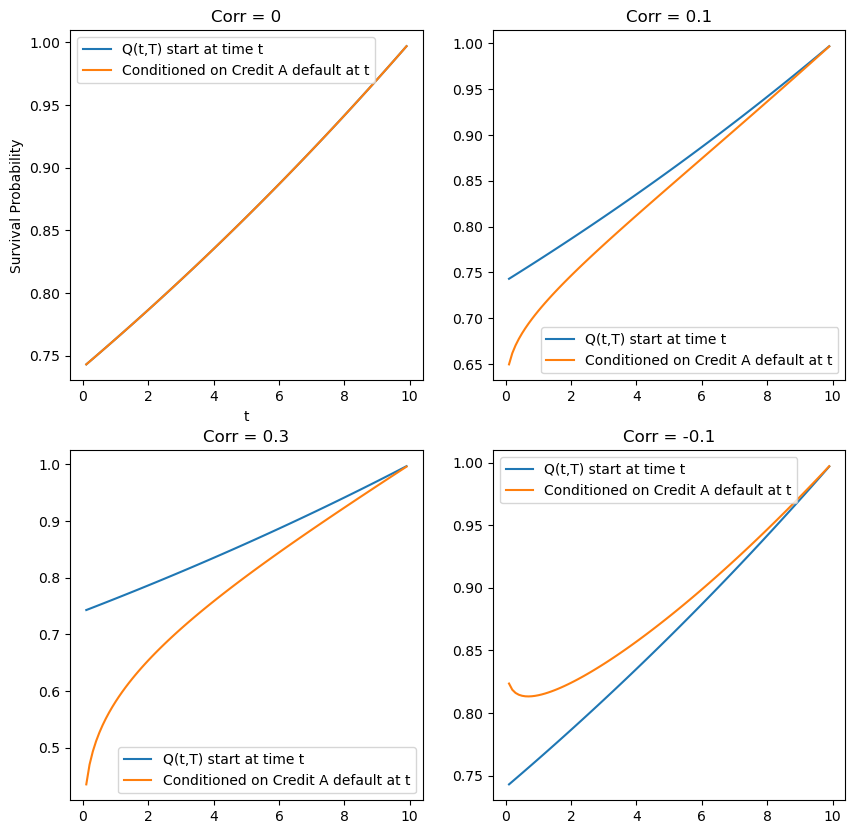

In [340]:
fig, ((ax1,ax2), (ax3,ax4)) = plt.subplots(2,2, figsize = (10,10))

ax1.plot(ts,survivals['Q(T|t)'], label = 'Q(t,T) start at time t')
ax1.plot(ts,survivals['Q(T|t) cond'],label ='Conditioned on Credit A default at t')
ax1.legend()
ax1.set_title('Corr = 0')
ax1.set_xlabel('t')
ax1.set_ylabel('Survival Probability')

ax2.plot(ts,survivals1['Q(T|t)'], label = 'Q(t,T) start at time t')
ax2.plot(ts,survivals1['Q(T|t) cond'],label ='Conditioned on Credit A default at t')
ax2.legend()
ax2.set_title('Corr = 0.1')

ax3.plot(ts,survivals2['Q(T|t)'], label = 'Q(t,T) start at time t')
ax3.plot(ts,survivals2['Q(T|t) cond'],label ='Conditioned on Credit A default at t')
ax3.legend()
ax3.set_title('Corr = 0.3')

ax4.plot(ts,survivals3['Q(T|t)'], label = 'Q(t,T) start at time t')
ax4.plot(ts,survivals3['Q(T|t) cond'],label ='Conditioned on Credit A default at t')
ax4.legend()
ax4.set_title('Corr = -0.1')

plt.show()

In [341]:
def forward_spread(corrs, haz2, haz1, R, ts, T, initial_s1, initial_s2):
    spreads = []
    for corr in corrs:
        survivals = calc_cond_surv(corr, haz2, ts, T,haz1)
        cond_haz = - np.log(survivals['Q(T|t) cond'].values.astype(float))/(T-ts)
        spread = cond_haz*(1-R)*10000
        spreads.append(spread)
    return spreads

In [342]:
ts = np.arange(0.01,5,.01)
corrs = [-.5,-.3,-.1,0,.1,.3,.5]
R = .3
haz2 = initial_s2*.0001/(1-R)
haz1 = initial_s1*.0001/(1-R)
T = 5
initial_s1 = 60
initial_s2 = 100
spreads = forward_spread(corrs, haz2, haz1, R, ts, T, initial_s1, initial_s2)

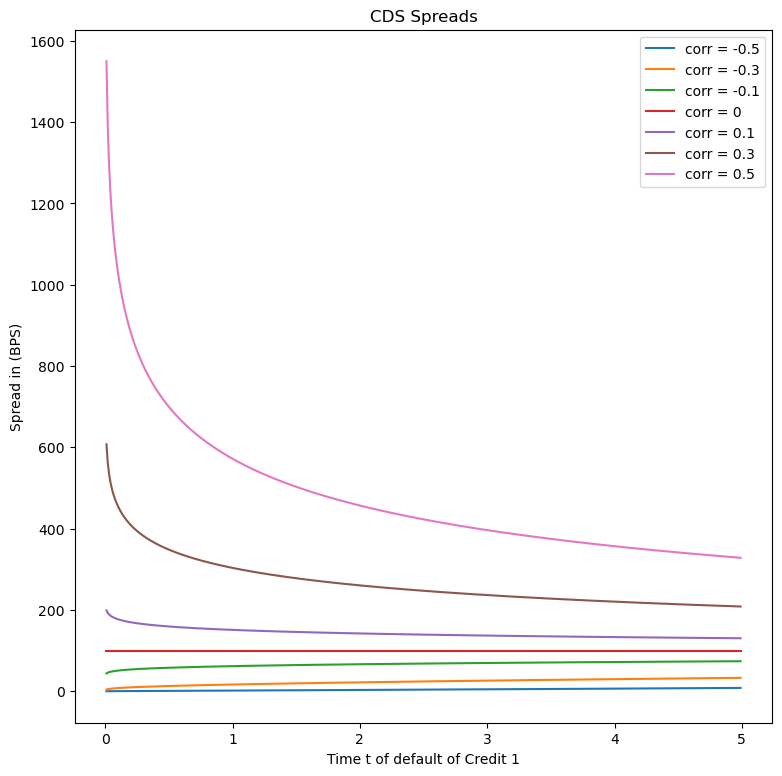

In [343]:
plt.figure(figsize=(9,9))
plt.plot(ts, spreads[0], label='corr = -0.5')
plt.plot(ts, spreads[1], label='corr = -0.3')
plt.plot(ts, spreads[2], label='corr = -0.1')
plt.plot(ts, spreads[3], label='corr = 0')
plt.plot(ts, spreads[4], label='corr = 0.1')
plt.plot(ts, spreads[5], label='corr = 0.3')
plt.plot(ts, spreads[6], label='corr = 0.5')
plt.xlabel('Time t of default of Credit 1')
plt.ylabel('Spread in (BPS)')
plt.title('CDS Spreads')
plt.legend()

plt.show()